In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
cal_fire_data = pd.read_csv("../data/cal_fire_data_cleaned.csv")
cal_fire_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42789 entries, 0 to 42788
Data columns (total 15 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   * Structure Type                             42789 non-null  object 
 1   * Roof Construction                          42789 non-null  object 
 2   * Eaves                                      42789 non-null  object 
 3   * Vent Screen                                42789 non-null  object 
 4   * Exterior Siding                            42789 non-null  object 
 5   * Window Pane                                42789 non-null  object 
 6   * Deck/Porch On Grade                        42789 non-null  object 
 7   * Deck/Porch Elevated                        42789 non-null  object 
 8   * Patio Cover/Carport Attached to Structure  42789 non-null  object 
 9   * Fence Attached to Structure                42789 non-null  object 
 10

In [3]:
cal_fire_data = pd.get_dummies(cal_fire_data, columns=cal_fire_data.select_dtypes('object').columns)
cal_fire_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42789 entries, 0 to 42788
Data columns (total 59 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Assessed Improved Value (parcel)                                    42789 non-null  float64
 1   Latitude                                                            42789 non-null  float64
 2   Longitude                                                           42789 non-null  float64
 3   Age                                                                 42789 non-null  float64
 4   Destroyed                                                           42789 non-null  int64  
 5   * Structure Type_Church                                             42789 non-null  bool   
 6   * Structure Type_Commercial Building Multi Story                    42789 non-null  bool   
 7   * Structure T

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
X = cal_fire_data.drop(columns='Destroyed')
y = cal_fire_data.Destroyed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=216, stratify=cal_fire_data['Destroyed'])

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
    'min_samples_split': [2, 4, 6, 8, 10, 12],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_depth': range(1, 8)
}


In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report


In [6]:
gbc = GradientBoostingClassifier(random_state=216)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=216)

grid_search = GridSearchCV(gbc, param_grid, cv=kfold, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("best_params:", grid_search.best_params_)
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 7560 candidates, totalling 37800 fits
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=2; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=2; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=2; total tim

In [7]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

best_gbc = grid_search.best_estimator_
preds = best_gbc.predict(X_test)
baseline_test_acc = accuracy_score(y_test, preds)
baseline_test_balanced_acc = balanced_accuracy_score(y_test, preds)
print(baseline_test_acc)
print(baseline_test_balanced_acc)


0.9107268053283477
0.9045730936074129


In [8]:
probabilities = best_gbc.predict_proba(X_test)
print(probabilities)


[[0.58258344 0.41741656]
 [0.0440021  0.9559979 ]
 [0.02640655 0.97359345]
 ...
 [0.98865751 0.01134249]
 [0.96928417 0.03071583]
 [0.93026477 0.06973523]]


In [9]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


In [10]:
print(precision_score(y_test, best_gbc.predict(X_test), average=None))
print(recall_score(y_test, best_gbc.predict(X_test), average=None))
print(f1_score(y_test, best_gbc.predict(X_test), average=None))


[0.91636364 0.90189019]
[0.93607038 0.87307581]
[0.92611219 0.88724911]


In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


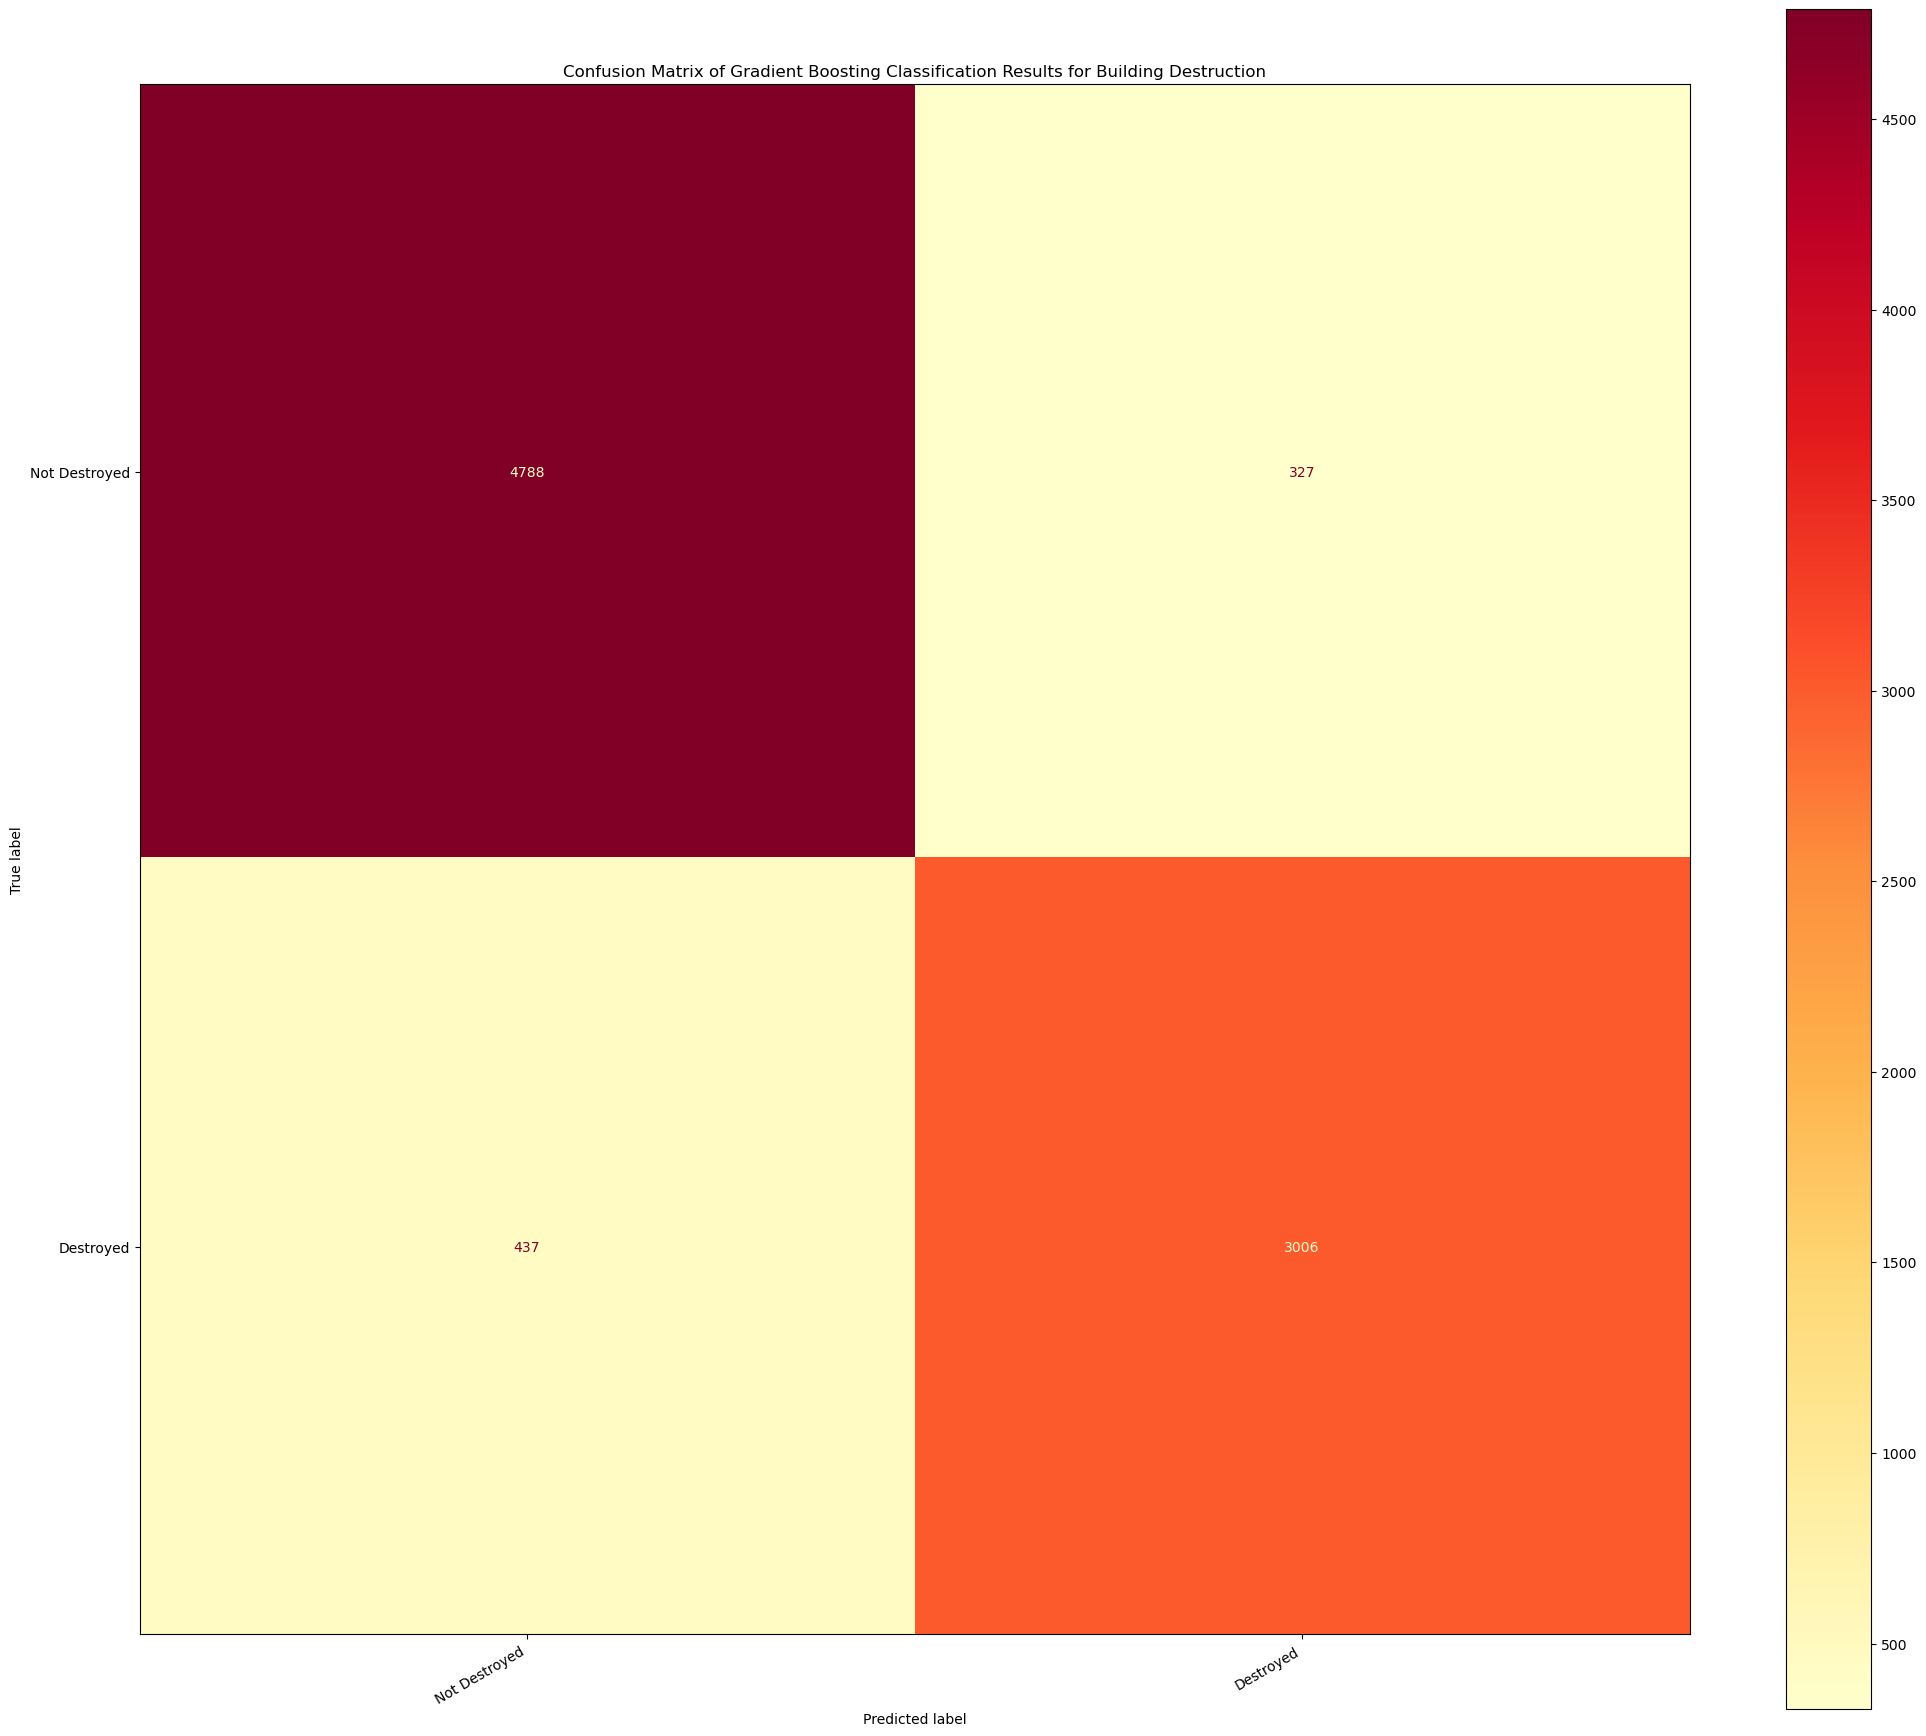

In [14]:
cm = confusion_matrix(y_test, best_gbc.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Destroyed', 'Destroyed'])
fig, ax = plt.subplots(figsize=(25, 25))
disp.plot(ax=ax, cmap='YlOrRd')
fig.autofmt_xdate()
plt.title("Confusion Matrix of Gradient Boosting Classification Results for Building Destruction")
plt.show()


In [13]:
from IPython.display import display
feature_df = pd.DataFrame({'feature': cal_fire_data.columns[:-1], 'importance': best_gbc.feature_importances_})
display(feature_df)


feature  importance
0                    Assessed Improved Value (parcel)    0.030123
1                                            Latitude    0.656388
2                                           Longitude    0.162072
3                                                 Age    0.022047
4                                           Destroyed    0.000062
5                             * Structure Type_Church    0.000415
6    * Structure Type_Commercial Building Multi Story    0.001128
7   * Structure Type_Commercial Building Single Story    0.000000
8                           * Structure Type_Hospital    0.000433
9                     * Structure Type_Infrastructure    0.000086
10      * Structure Type_Mixed Commercial/Residential    0.005240
11           * Structure Type_Mobile Home Double Wide    0.000380
12           * Structure Type_Mobile Home Single Wide    0.000500
13           * Structure Type_Mobile Home Triple Wide    0.000903
14                        * Structure Type_Motor Home    0.000446
15  * Structure Type_Multi Family Residence Multi ...    0.000048
16  * Structure Type_Multi Family Residence Single...    0.000015
17                            * Structure Type_School    0.000934
18  * Structure Type_Single Family Residence Multi...    0.001730
19  * Structure Type_Single Family Residence Singl...    0.001012
20            * Structure Type_Utility Misc Structure    0.002385
21                        * Roof Construction_Asphalt    0.000520
22                       * Roof Construction_Concrete    0.001767
23                          * Roof Construction_Metal    0.000157
24                          * Roof Construction_Other    0.002326
25                           * Roof Construction_Tile    0.000439
26                           * Roof Construction_Wood    0.002399
27                                   * Eaves_Enclosed    0.009275
28                                   * Eaves_No Eaves    0.001549
29                                 * Eaves_Unenclosed    0.002528
30                 * Vent Screen_Mesh Screen <= 1/8""    0.007670
31                  * Vent Screen_Mesh Screen > 1/8""    0.003903
32                             * Vent Screen_No Vents    0.001056
33                           * Vent Screen_Unscreened    0.009168
34                      * Exterior Siding_Combustible    0.011719
35               * Exterior Siding_Ignition Resistant    0.001272
36                            * Exterior Siding_Metal    0.000282
37                            * Exterior Siding_Other    0.002884
38              * Exterior Siding_Stucco Brick Cement    0.000183
39              * Exterior Siding_Stucco/Brick/Cement    0.000622
40                            * Exterior Siding_Vinyl    0.015854
41                             * Exterior Siding_Wood    0.010171
42                           * Window Pane_Multi Pane    0.001248
43                           * Window Pane_No Windows    0.002543
44                          * Window Pane_Single Pane    0.000088
45                    * Deck/Porch On Grade_Composite    0.001500
46             * Deck/Porch On Grade_Masonry/Concrete    0.002909
47                * Deck/Porch On Grade_No Deck/Porch    0.000593
48                         * Deck/Porch On Grade_Wood    0.000299
49                    * Deck/Porch Elevated_Composite    0.000797
50             * Deck/Porch Elevated_Masonry/Concrete    0.002521
51                * Deck/Porch Elevated_No Deck/Porch    0.000752
52                         * Deck/Porch Elevated_Wood    0.000764
53  * Patio Cover/Carport Attached to Structure_Co...    0.001280
54  * Patio Cover/Carport Attached to Structure_No...    0.001202
55  * Patio Cover/Carport Attached to Structure_No...    0.005470
56          * Fence Attached to Structure_Combustible    0.004624
57             * Fence Attached to Structure_No Fence    0.001322